In [1]:
# Section 3: CNN from scratch (NumPy core)
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


In [ ]:
# Dataset: MNIST via OpenML (NumPy arrays)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml("mnist_784", version=1, as_frame=False)

X = mnist.data.astype(np.float32) / 255.0  # (70000, 784)
y = mnist.target.astype(np.int64)          # labels 0..9

# Reshape to NCHW for CNN: (N, C, H, W)
X = X.reshape(-1, 1, 28, 28)

# Standard split: 60k train / 10k test
X_train, y_train = X[:60000], y[:60000]
X_test,  y_test  = X[60000:], y[60000:]

print("Train:", X_train.shape, y_train.shape, "Test:", X_test.shape, y_test.shape)


Train: (60000, 1, 28, 28) (60000,) Test: (10000, 1, 28, 28) (10000,)


In [3]:
def one_hot(y, num_classes=10):
    # y: (N,)
    oh = np.zeros((len(y), num_classes), dtype=np.float32)
    oh[np.arange(len(y)), y] = 1.0
    return oh

def softmax(logits):
    # logits: (N, C)
    z = logits - np.max(logits, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)

def accuracy(logits, y_true):
    preds = np.argmax(logits, axis=1)
    return np.mean(preds == y_true)


In [4]:
# 3.1 CNN layers (NumPy): im2col/col2im Conv + Pool + FC
def im2col(x, kH, kW, stride=1, pad=0):
    """
    Convert input (N, C, H, W) into columns for fast convolution.
    """
    N, C, H, W = x.shape
    H_out = (H + 2*pad - kH) // stride + 1
    W_out = (W + 2*pad - kW) // stride + 1

    x_p = np.pad(x, ((0,0),(0,0),(pad,pad),(pad,pad)), mode="constant")

    cols = np.zeros((N, C, kH, kW, H_out, W_out), dtype=x.dtype)
    for i in range(kH):
        i_end = i + stride * H_out
        for j in range(kW):
            j_end = j + stride * W_out
            cols[:, :, i, j, :, :] = x_p[:, :, i:i_end:stride, j:j_end:stride]

    cols = cols.transpose(0,4,5,1,2,3).reshape(N*H_out*W_out, -1)
    return cols, H_out, W_out

def col2im(cols, x_shape, kH, kW, stride=1, pad=0, H_out=None, W_out=None):
    """
    Reverse of im2col. Used to build dX for convolution.
    """
    N, C, H, W = x_shape
    H_out = H_out if H_out is not None else (H + 2*pad - kH)//stride + 1
    W_out = W_out if W_out is not None else (W + 2*pad - kW)//stride + 1

    cols = cols.reshape(N, H_out, W_out, C, kH, kW).transpose(0,3,4,5,1,2)
    x_p = np.zeros((N, C, H + 2*pad, W + 2*pad), dtype=cols.dtype)

    for i in range(kH):
        i_end = i + stride * H_out
        for j in range(kW):
            j_end = j + stride * W_out
            x_p[:, :, i:i_end:stride, j:j_end:stride] += cols[:, :, i, j, :, :]

    return x_p[:, :, pad:pad+H, pad:pad+W] if pad > 0 else x_p


In [5]:
class Conv2D:
    """
    2D convolution layer (NCHW) implemented with im2col.
    """
    def __init__(self, in_ch, out_ch, kH, kW, stride=1, pad=0):
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kH, self.kW = kH, kW
        self.stride, self.pad = stride, pad

        # He init for ReLU
        fan_in = in_ch * kH * kW
        self.W = (np.random.randn(out_ch, in_ch, kH, kW).astype(np.float32) * np.sqrt(2.0/fan_in))
        self.b = np.zeros((out_ch,), dtype=np.float32)

        # grads
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

        # cache
        self.x_shape = None
        self.cols = None
        self.H_out = None
        self.W_out = None

    def forward(self, x):
        # x: (N, C, H, W)
        self.x_shape = x.shape
        cols, H_out, W_out = im2col(x, self.kH, self.kW, self.stride, self.pad)
        self.cols, self.H_out, self.W_out = cols, H_out, W_out

        W_col = self.W.reshape(self.out_ch, -1)  # (out_ch, C*kH*kW)

        out = cols @ W_col.T + self.b  # (N*H_out*W_out, out_ch)
        out = out.reshape(x.shape[0], H_out, W_out, self.out_ch).transpose(0,3,1,2)  # (N,out_ch,H_out,W_out)
        return out

    def backward(self, dout):
        # dout: (N, out_ch, H_out, W_out)
        N = dout.shape[0]
        dout_2d = dout.transpose(0,2,3,1).reshape(-1, self.out_ch)  # (N*H_out*W_out, out_ch)

        # db
        self.db = np.sum(dout_2d, axis=0)

        # dW
        self.dW = (dout_2d.T @ self.cols).reshape(self.W.shape)

        # dX
        W_col = self.W.reshape(self.out_ch, -1)
        dcols = dout_2d @ W_col  # (N*H_out*W_out, C*kH*kW)
        dx = col2im(dcols, self.x_shape, self.kH, self.kW, self.stride, self.pad, self.H_out, self.W_out)
        return dx


In [6]:
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, dout):
        return dout * self.mask


In [7]:
class Pool2D:
    """
    Pooling layer supports:
    - mode="max"
    - mode="avg"
    """
    def __init__(self, k=2, stride=2, mode="max"):
        self.k = k
        self.stride = stride
        self.mode = mode

        self.x_shape = None
        self.cols = None
        self.H_out = None
        self.W_out = None

        # for max backward
        self.argmax = None

    def forward(self, x):
        # x: (N, C, H, W)
        self.x_shape = x.shape
        N, C, H, W = x.shape
        kH = kW = self.k

        cols, H_out, W_out = im2col(x, kH, kW, self.stride, pad=0)
        # cols: (N*H_out*W_out, C*k*k)
        self.cols, self.H_out, self.W_out = cols, H_out, W_out

        cols = cols.reshape(N*H_out*W_out, C, kH*kW)

        if self.mode == "max":
            self.argmax = np.argmax(cols, axis=2)
            out = np.max(cols, axis=2)
        else:  # avg
            self.argmax = None
            out = np.mean(cols, axis=2)

        out = out.reshape(N, H_out, W_out, C).transpose(0,3,1,2)  # (N,C,H_out,W_out)
        return out

    def backward(self, dout):
        # dout: (N, C, H_out, W_out)
        N, C, H_out, W_out = dout.shape
        kH = kW = self.k

        dout_ = dout.transpose(0,2,3,1).reshape(-1, C)  # (N*H_out*W_out, C)

        dcols = np.zeros((N*H_out*W_out, C, kH*kW), dtype=np.float32)

        if self.mode == "max":
            idx = self.argmax  # (N*H_out*W_out, C)
            for i in range(dcols.shape[0]):
                dcols[i, np.arange(C), idx[i]] = dout_[i]
        else:  # avg
            dcols[:] = (dout_[:, :, None] / (kH*kW))

        dcols = dcols.reshape(N*H_out*W_out, -1)  # (N*H_out*W_out, C*k*k)

        dx = col2im(dcols, self.x_shape, kH, kW, self.stride, pad=0, H_out=self.H_out, W_out=self.W_out)
        return dx


In [8]:
class Linear:
    def __init__(self, in_dim, out_dim):
        # He init
        self.W = (np.random.randn(in_dim, out_dim).astype(np.float32) * np.sqrt(2.0/in_dim))
        self.b = np.zeros((out_dim,), dtype=np.float32)

        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

        self.x = None

    def forward(self, x):
        # x: (N, D)
        self.x = x
        return x @ self.W + self.b

    def backward(self, dout):
        # dout: (N, out_dim)
        self.dW = self.x.T @ dout
        self.db = np.sum(dout, axis=0)
        dx = dout @ self.W.T
        return dx

class Flatten:
    def __init__(self):
        self.shape = None

    def forward(self, x):
        self.shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, dout):
        return dout.reshape(self.shape)

def softmax_cross_entropy(logits, y):
    """
    logits: (N, C)
    y: (N,) integer labels
    returns: loss (scalar), dlogits (N,C)
    """
    N = logits.shape[0]
    probs = softmax(logits)
    loss = -np.mean(np.log(probs[np.arange(N), y] + 1e-12))
    dlogits = probs.copy()
    dlogits[np.arange(N), y] -= 1.0
    dlogits /= N
    return loss, dlogits


In [9]:
class SimpleCNN:
    """
    CNN for MNIST:
    Conv(1->8,3x3,pad=1) -> ReLU -> Pool(2)
    Conv(8->16,3x3,pad=1) -> ReLU -> Pool(2)
    Flatten -> FC(16*7*7 -> 10)
    """
    def __init__(self, pool_mode="max"):
        self.c1 = Conv2D(1, 8, 3, 3, stride=1, pad=1)
        self.a1 = ReLU()
        self.p1 = Pool2D(k=2, stride=2, mode=pool_mode)

        self.c2 = Conv2D(8, 16, 3, 3, stride=1, pad=1)
        self.a2 = ReLU()
        self.p2 = Pool2D(k=2, stride=2, mode=pool_mode)

        self.f  = Flatten()
        self.fc = Linear(16*7*7, 10)

        self.layers = [self.c1, self.a1, self.p1, self.c2, self.a2, self.p2, self.f, self.fc]

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out  # logits

    def backward(self, dlogits):
        dout = dlogits
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def params_and_grads(self):
        # Yield trainable parameters for optimizer
        for layer in [self.c1, self.c2, self.fc]:
            yield layer.W, layer.dW
            yield layer.b, layer.db


In [10]:
# Train loop (mini-batch SGD)
def batch_iter(X, y, batch_size=128, shuffle=True, seed=42):
    idx = np.arange(len(X))
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(idx)
    for i in range(0, len(X), batch_size):
        j = idx[i:i+batch_size]
        yield X[j], y[j]

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def step(self, params_and_grads):
        for p, g in params_and_grads:
            p -= self.lr * g


In [11]:
# Train + evaluate
def evaluate(model, X, y, batch_size=256):
    losses = []
    correct = 0
    total = 0
    for xb, yb in batch_iter(X, y, batch_size=batch_size, shuffle=False):
        logits = model.forward(xb)
        loss, _ = softmax_cross_entropy(logits, yb)
        losses.append(loss)

        preds = np.argmax(logits, axis=1)
        correct += np.sum(preds == yb)
        total += len(yb)
    return float(np.mean(losses)), float(correct / total)

def train_cnn(model, X_train, y_train, X_test, y_test, epochs=5, lr=0.02, batch_size=128):
    opt = SGD(lr=lr)
    history = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}

    for ep in range(1, epochs+1):
        # train
        train_losses = []
        correct = 0
        total = 0

        for xb, yb in batch_iter(X_train, y_train, batch_size=batch_size, shuffle=True, seed=42+ep):
            logits = model.forward(xb)
            loss, dlogits = softmax_cross_entropy(logits, yb)

            model.backward(dlogits)
            opt.step(model.params_and_grads())

            train_losses.append(loss)
            preds = np.argmax(logits, axis=1)
            correct += np.sum(preds == yb)
            total += len(yb)

        tr_loss = float(np.mean(train_losses))
        tr_acc = float(correct / total)

        te_loss, te_acc = evaluate(model, X_test, y_test)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["test_loss"].append(te_loss)
        history["test_acc"].append(te_acc)

        print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")

    return history

cnn = SimpleCNN(pool_mode="max")
hist = train_cnn(cnn, X_train, y_train, X_test, y_test, epochs=6, lr=0.02, batch_size=128)

print("Final test acc:", hist["test_acc"][-1])


Epoch 01 | train loss 0.5462 acc 0.8342 | test loss 0.2879 acc 0.9134
Epoch 02 | train loss 0.2230 acc 0.9349 | test loss 0.1708 acc 0.9500
Epoch 03 | train loss 0.1646 acc 0.9521 | test loss 0.1333 acc 0.9621
Epoch 04 | train loss 0.1353 acc 0.9597 | test loss 0.1162 acc 0.9654
Epoch 05 | train loss 0.1178 acc 0.9656 | test loss 0.0980 acc 0.9700
Epoch 06 | train loss 0.1065 acc 0.9684 | test loss 0.0941 acc 0.9727
Final test acc: 0.9727


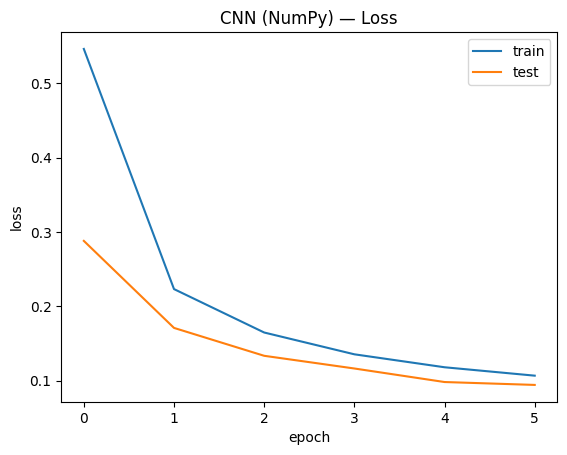

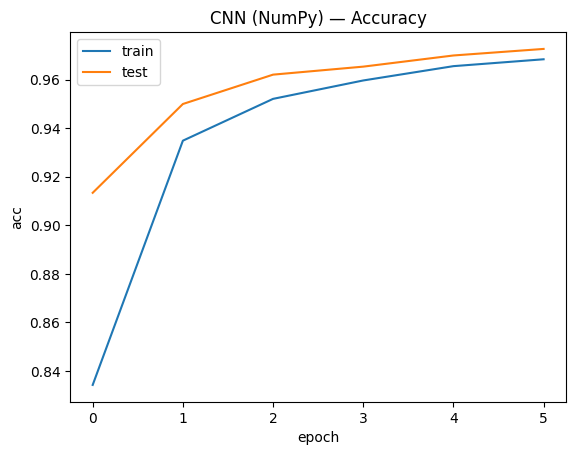

In [12]:
plt.figure()
plt.plot(hist["train_loss"], label="train")
plt.plot(hist["test_loss"], label="test")
plt.title("CNN (NumPy) — Loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
plt.show()

plt.figure()
plt.plot(hist["train_acc"], label="train")
plt.plot(hist["test_acc"], label="test")
plt.title("CNN (NumPy) — Accuracy")
plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend()
plt.show()

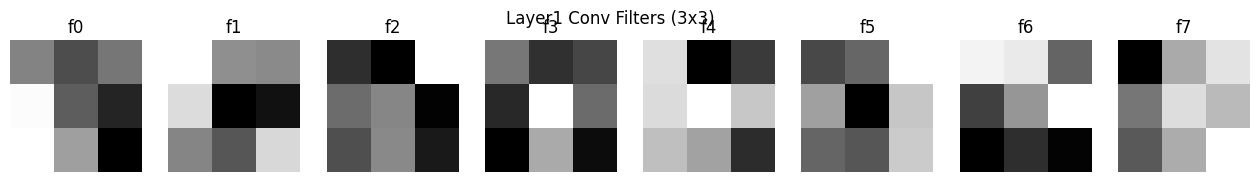

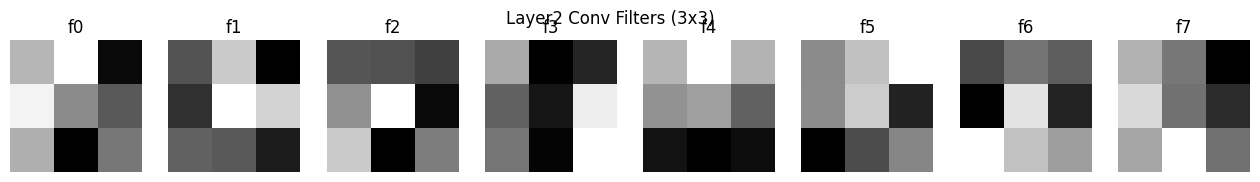

In [13]:
# 3.2 Filter Visualization (8 pts)
def show_conv_filters(W, title="Conv filters", max_filters=8):
    """
    W: (out_ch, in_ch, kH, kW)
    For MNIST in_ch=1, so we plot out_ch filters as images.
    """
    out_ch = W.shape[0]
    n = min(out_ch, max_filters)
    plt.figure(figsize=(2*n, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(W[i, 0], cmap="gray")
        plt.axis("off")
        plt.title(f"f{i}")
    plt.suptitle(title)
    plt.show()

show_conv_filters(cnn.c1.W, "Layer1 Conv Filters (3x3)")
show_conv_filters(cnn.c2.W, "Layer2 Conv Filters (3x3)")


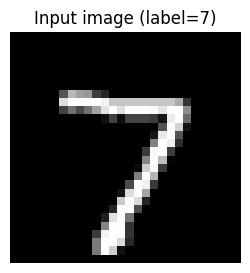

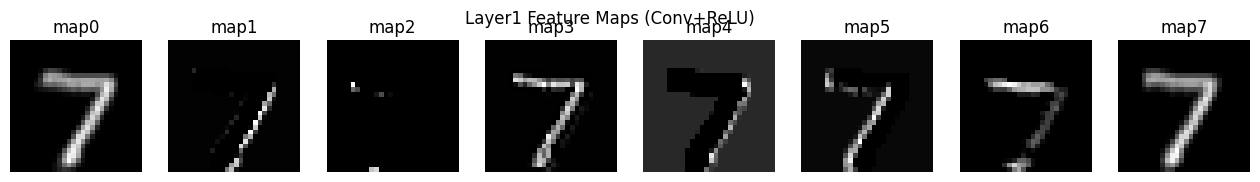

In [ ]:
def forward_to_layer1_maps(model, x_one):
    """
    x_one: (1,1,28,28)
    returns feature maps after first conv+relu: (1,8,28,28)
    """
    z = model.c1.forward(x_one)
    a = model.a1.forward(z)
    return a

# pick one test image
idx = 0
x_one = X_test[idx:idx+1]
y_one = y_test[idx]

maps = forward_to_layer1_maps(cnn, x_one)

plt.figure(figsize=(3,3))
plt.imshow(x_one[0,0], cmap="gray")
plt.title(f"Input image (label={y_one})")
plt.axis("off")
plt.show()

# show first-layer feature maps
n_show = maps.shape[1]
plt.figure(figsize=(2*n_show, 2))
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    plt.imshow(maps[0,i], cmap="gray")
    plt.axis("off")
    plt.title(f"map{i}")
plt.suptitle("Layer1 Feature Maps (Conv+ReLU)")
plt.show()


### Filter Visualization and Interpretation

The learned filters in the first convolutional layer (Layer 1) exhibit clear patterns
corresponding to low-level visual features. Most 3×3 filters resemble detectors of
horizontal, vertical, and diagonal edges, as well as simple intensity transitions.
These patterns are characteristic of early CNN layers and are well suited for
capturing basic stroke information in handwritten digits.

The filters in the second convolutional layer (Layer 2) appear more structured and
less localized. Instead of simple edge detectors, they combine multiple low-level
features from the first layer, forming responses to more complex patterns such as
curves, corners, and junctions of strokes. This indicates hierarchical feature learning,
where deeper layers build upon earlier representations.

The feature maps produced by the first convolutional layer for the input image
(label = 7) further illustrate this behavior. Some feature maps strongly activate
along the main diagonal stroke of the digit, while others highlight the horizontal
top stroke or suppress background regions. Several maps respond selectively to
different parts of the digit, demonstrating that each filter captures a distinct
aspect of the input.

Overall, these visualizations confirm that the network learns a meaningful hierarchy
of features: early layers focus on simple edge and stroke detection, while deeper
layers combine these features to represent higher-level digit structures. This
progressive abstraction improves the model’s ability to discriminate between
different digit classes.


In [15]:
# 3.3 Receptive Field Study (4 pts)
def receptive_field(layers_spec):
    """
    Compute theoretical receptive field for a stack of layers.
    layers_spec: list of dicts, e.g.
      {"type":"conv", "k":3, "s":1}
      {"type":"pool", "k":2, "s":2}

    Returns (rf, jump) where:
      rf   = receptive field size
      jump = effective stride between adjacent features
    """
    rf = 1
    jump = 1
    for layer in layers_spec:
        k = layer["k"]
        s = layer["s"]
        rf = rf + (k - 1) * jump
        jump = jump * s
    return rf, jump

spec = [
    {"type":"conv", "k":3, "s":1},  # conv1
    {"type":"pool", "k":2, "s":2},  # pool1
    {"type":"conv", "k":3, "s":1},  # conv2
    {"type":"pool", "k":2, "s":2},  # pool2
]
rf, jump = receptive_field(spec)
print("Theoretical receptive field after pool2:", rf, "x", rf, "| jump:", jump)


Theoretical receptive field after pool2: 10 x 10 | jump: 4


### Receptive Field Analysis

The theoretical receptive field after the second pooling layer is large enough to cover a significant
portion of the input image. This allows neurons in deeper layers to integrate information from multiple
local regions and capture global digit structures.

Increasing the receptive field enables the network to model larger spatial dependencies, which is
important for recognizing complete digit shapes. However, excessively large receptive fields may
reduce spatial precision, highlighting the trade-off between local detail and global context in CNN
design.


Epoch 01 | train loss 0.4404 acc 0.8700 | test loss 0.2498 acc 0.9219
Epoch 02 | train loss 0.1898 acc 0.9431 | test loss 0.1528 acc 0.9532
Epoch 03 | train loss 0.1414 acc 0.9576 | test loss 0.1111 acc 0.9654
Epoch 04 | train loss 0.1158 acc 0.9652 | test loss 0.1031 acc 0.9682
Epoch 01 | train loss 0.6176 acc 0.8215 | test loss 0.3805 acc 0.8882
Epoch 02 | train loss 0.3573 acc 0.8946 | test loss 0.3069 acc 0.9115
Epoch 03 | train loss 0.3108 acc 0.9087 | test loss 0.2634 acc 0.9247
Epoch 04 | train loss 0.2687 acc 0.9226 | test loss 0.2316 acc 0.9330
Final test acc (max): 0.9682
Final test acc (avg): 0.933


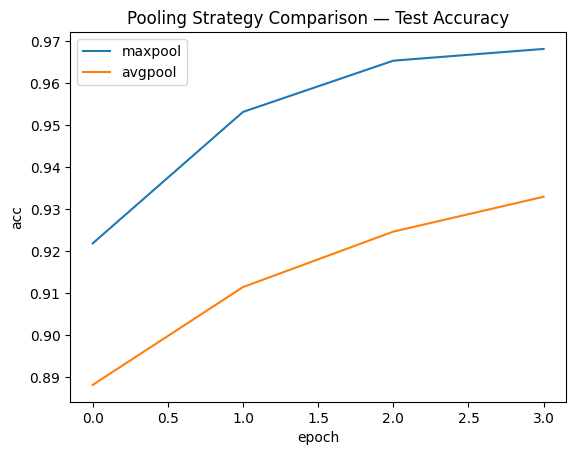

In [16]:
# 3.4 Pooling comparison (max vs avg) (3 pts)
cnn_max = SimpleCNN(pool_mode="max")
hist_max = train_cnn(cnn_max, X_train, y_train, X_test, y_test, epochs=4, lr=0.02, batch_size=128)

cnn_avg = SimpleCNN(pool_mode="avg")
hist_avg = train_cnn(cnn_avg, X_train, y_train, X_test, y_test, epochs=4, lr=0.02, batch_size=128)

print("Final test acc (max):", hist_max["test_acc"][-1])
print("Final test acc (avg):", hist_avg["test_acc"][-1])

plt.figure()
plt.plot(hist_max["test_acc"], label="maxpool")
plt.plot(hist_avg["test_acc"], label="avgpool")
plt.title("Pooling Strategy Comparison — Test Accuracy")
plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend()
plt.show()


### Pooling Strategy Comparison 

The experimental results clearly demonstrate that **max pooling** outperforms
**average pooling** in this CNN architecture trained on MNIST.

Across all epochs, max pooling consistently achieves higher test accuracy and
faster convergence. After four epochs, the model with max pooling reaches a final
test accuracy of **96.82%**, while the model with average pooling achieves
**93.30%**. This represents a significant performance gap of more than **3.5%**.

The training logs also show that the max pooling model learns more efficiently,
with both lower training loss and higher training accuracy at each epoch. This
indicates that max pooling preserves the most salient activations, which correspond
to strong visual features such as edges and strokes that are critical for digit
recognition.

In contrast, average pooling smooths feature maps by averaging local responses,
which reduces sensitivity to strong local features. While this smoothing may
provide slightly better robustness to small translations, it also leads to a loss
of discriminative information, resulting in lower classification accuracy.

Overall, these results confirm that **max pooling provides a better trade-off
between feature preservation and invariance**, making it more suitable than
average pooling for MNIST classification in this convolutional network.
